## 1. Importing libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, auc, roc_curve, precision_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from lightgbm import LGBMClassifier

## 2. Loading Datasets:



In [6]:
train_data = pd.read_csv('/content/train.csv',encoding = 'ISO-8859-1')
test_data = pd.read_csv('/content/test.csv')
address = pd.read_csv('/content/addresses.csv')
latlons = pd.read_csv('/content/latlons.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
train_data.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sim, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [8]:
train_data.shape

(250306, 34)

## 3. Data Processing

### 3.1 Data Linkage

### Combine the address data and lalo (latitude and longtitude) data together

### Combine the address_lalo data with train and test by joining with 'ticket_id'

In [9]:
address_lalo = address.set_index('address').join(latlons.set_index('address'), how='left').dropna().reset_index(drop=False)
train_data=pd.merge(train_data, address_lalo, on='ticket_id').set_index('ticket_id')
test_data=pd.merge(test_data, address_lalo, on='ticket_id',how='left').set_index('ticket_id')

In [10]:
train_data.isnull().sum()

agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250302
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250299
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
balance_due                        0
p

## 3.2 Dropping variables that don't provide useful information

* 'non_us_str_code', 'violation_zip_code' and 'grafitti_status' has near 100% missing values
* 'address' will be dropped since we can use latitude and longtitude of the address as continous variables
* The following columns will be dropped since it only appears in train_data not in test_data: 'payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance_detail'.

In [11]:
train_only_columns = [col for col in train_data.columns if col not in test_data.columns]
train_only_columns.remove('compliance')
train_only_columns

['payment_amount',
 'balance_due',
 'payment_date',
 'payment_status',
 'collection_status',
 'compliance_detail']

In [12]:
train_data.drop(train_only_columns,axis=1,inplace=True)
train_data.drop(['non_us_str_code','violation_zip_code','grafitti_status'],axis=1,inplace=True)

## 3.3 Define a new variable called 'time_gap' to calcualte the time gap between 'hearding_date' and 'ticket_issued_date'.

### Since some of our hearing_date and ticket_issued_date has missing values, about 3% of the total training data, we simply replace the missing values with the average for the time_gap

In [13]:
from datetime import datetime
temp = pd.DataFrame()
temp['hd'] = train_data['hearing_date']
temp['ti'] = train_data['ticket_issued_date']
temp.dropna(axis=0)

temp['hd'] = pd.to_datetime(temp['hd'])
temp['ti'] = pd.to_datetime(temp['ti'])

temp['gap'] = temp['hd'] - temp['ti']
temp.gap.mean()

Timedelta('76 days 06:50:36.412108776')

In [14]:
from datetime import datetime
def time_gap(hearing_date_str, ticket_issued_date_str):
    if not hearing_date_str or type(hearing_date_str)!=str: return 76
    hearing_date = datetime.strptime(hearing_date_str, "%Y-%m-%d %H:%M:%S")
    ticket_issued_date = datetime.strptime(ticket_issued_date_str, "%Y-%m-%d %H:%M:%S")
    gap = hearing_date - ticket_issued_date
    return gap.days

In [15]:
train_data['time_gap'] = train_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
test_data['time_gap'] = test_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)

## 3.4 Making sure our categorical columns are of type categorical

In [16]:
feature_columns = [
        'agency_name',
        'violation_street_name',
        'state',
        'violation_code',
        'late_fee',
        'fine_amount',
        'discount_amount',
        'judgment_amount',
        'lat',
        'lon',
        'time_gap'#'ticket_issued_date' -  'hearing_date'
]

In [17]:
convert_columns = {
        'agency_name':'category',
        'violation_street_name':'category',
        'state':'category',
        'violation_code':'category',
        'disposition':'category',
        'inspector_name':'category',
        'city':'category',
        'country':'category'
    }

In [18]:
for df in [train_data,test_data]:
    for col, col_type in convert_columns.items():
        if col in df:
            if col_type == 'category':
                  df[col] = df[col].astype(col_type)

## 3.5 Since our target variable 'compliance' also has 90425 na values, we simply remove the missing rows.

In [19]:
train_data['compliance'].isnull().sum()

90425

In [20]:
train_data = train_data[(train_data['compliance'] == 0) | (train_data['compliance'] == 1)]

## 4. Data Visualization

### Distribution of response variable: Compliance
### Our target variable 'compliance' is very imbalanced. We have over 140,000 number of training data that is non-compliance and less than 200,000 trianing data that is compliance.

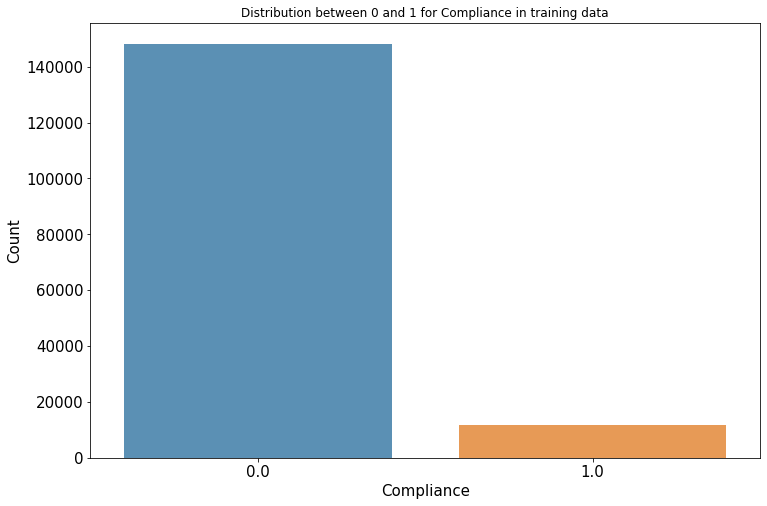

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(data=train_data,x='compliance',alpha=0.8)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Compliance',size=15)
plt.ylabel('Count',size=15)
plt.title('Distribution between 0 and 1 for Compliance in training data')
plt.show()

### 4.1 Distribution of 'agency_name' for different category of compliance
### Because our dataset is very imbalanced, so it is very hard to tell if a particular agency tend to favour a particular compliance value in order to create a distinction. 

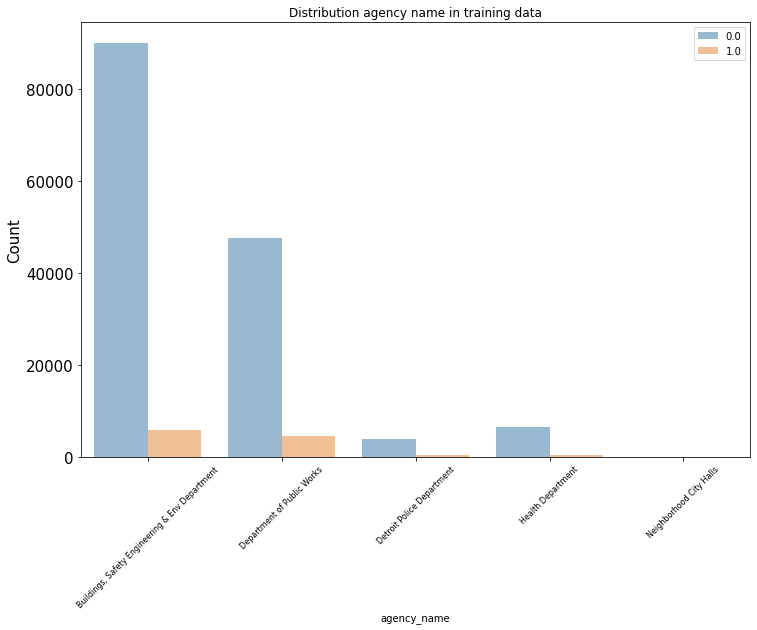

In [22]:
plt.figure(figsize=(12,8))
sns.countplot(data=train_data,x='agency_name',hue='compliance',alpha=0.5)
plt.ylabel('Count',size=15)
plt.xticks(rotation=45,size=8)
plt.yticks(size=15)
plt.legend(loc='upper right')
plt.title('Distribution agency name in training data')
plt.show()

In [23]:
agency_name_group = train_data[['agency_name','compliance','fine_amount']].groupby(['agency_name','compliance']).count()
agency_name_group.columns = ['count']
agency_name_group['percent'] = agency_name_group.groupby(level=0).apply(lambda x: 100*(x/x.sum()))
agency_name_group

count     percent
agency_name                                    compliance                   
Buildings, Safety Engineering & Env Department 0.0         90038   93.925580
                                               1.0          5823    6.074420
Department of Public Works                     0.0         47726   91.003737
                                               1.0          4718    8.996263
Detroit Police Department                      0.0          3876   86.827957
                                               1.0           588   13.172043
Health Department                              0.0          6639   93.414943
                                               1.0           468    6.585057
Neighborhood City Halls                        0.0             1  100.000000
                                               1.0             0    0.000000

### 4.2 By disposition, similiar from agency name, due to the fact that our data is very imbalanced, it is hard to tell distinction between compliances across each categories.

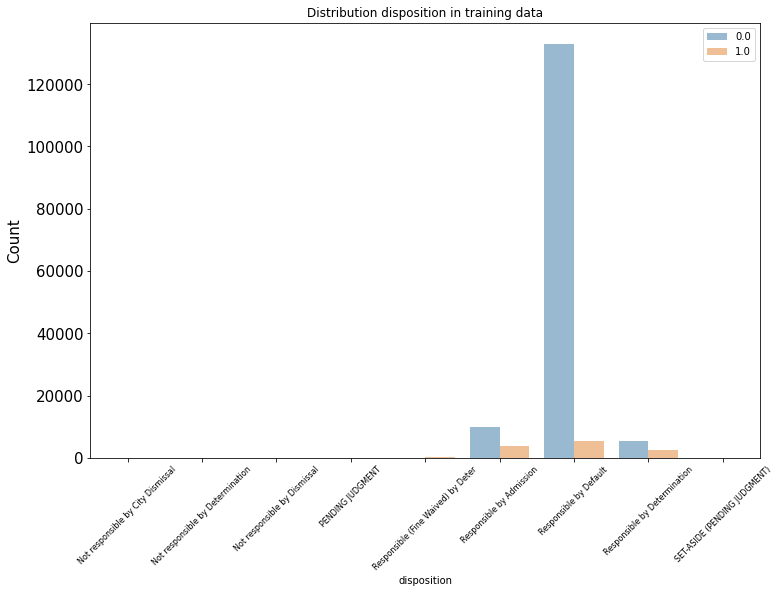

In [24]:
plt.figure(figsize=(12,8))
sns.countplot(data=train_data,x='disposition',hue='compliance',alpha=0.5)
plt.ylabel('Count',size=15)
plt.xticks(rotation=45,size=8)
plt.yticks(size=15)
plt.legend(loc='upper right')
plt.title('Distribution disposition in training data')
plt.show()

In [25]:
disposition_group = train_data[['disposition','compliance','fine_amount']].groupby(['disposition','compliance']).count()
disposition_group.columns = ['count']
disposition_group['percent'] = disposition_group.groupby(level=0).apply(lambda x: 100*(x/x.sum()))
disposition_group.dropna()

count     percent
disposition                        compliance                    
Responsible (Fine Waived) by Deter 0.0              0    0.000000
                                   1.0            195  100.000000
Responsible by Admission           0.0           9933   72.498358
                                   1.0           3768   27.501642
Responsible by Default             0.0         133052   96.179619
                                   1.0           5285    3.820381
Responsible by Determination       0.0           5295   69.270016
                                   1.0           2349   30.729984

### 4.3 Fine amount vs compliance in a box plot shows the median fine difference between compliance and non-compliance. It is clear that the median amount for compliance is lower than median of non-compliance.

Text(0.5, 1.0, 'Fine amount vs compliance (zoomed in)')

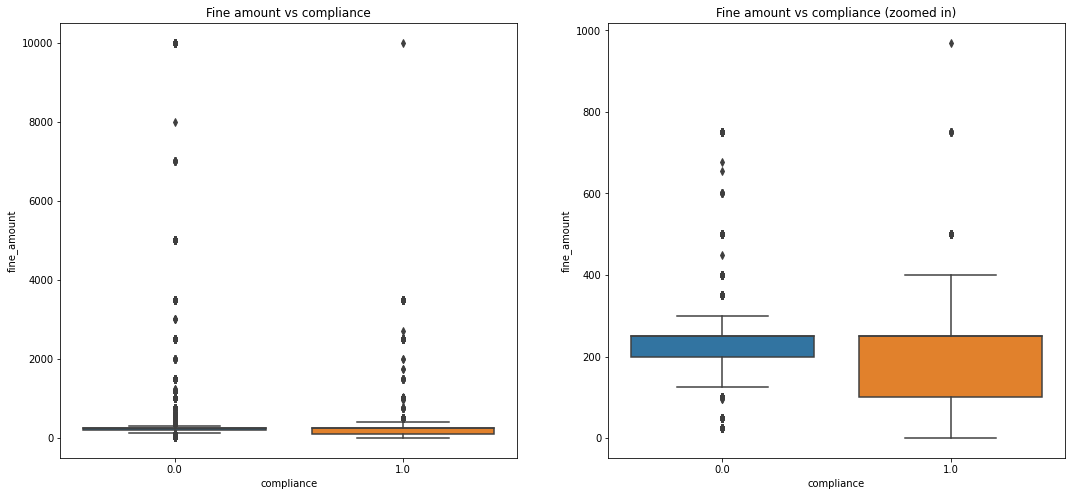

In [26]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_data,y='fine_amount',x='compliance')
plt.title('Fine amount vs compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_data[train_data['fine_amount']<1000],y='fine_amount',x='compliance')
plt.title('Fine amount vs compliance (zoomed in)')

### 4.4 Ploting compliance vs admin fee shows constant admin fees, since everyone is having the same amount of admin fee, it is no point to include admin fee in our model.

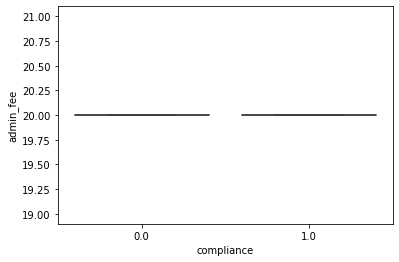

In [27]:
sns.boxplot(data=train_data,y='admin_fee',x='compliance')

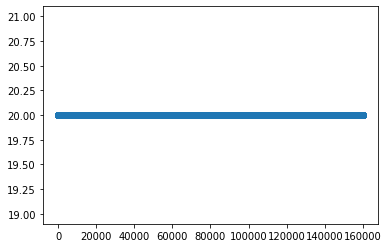

In [28]:
plt.scatter(range(len(train_data['admin_fee'])),train_data['admin_fee'])

### 4.5 Similiar with state fee which is $10 for everyone, we should also not include this variable in our model.

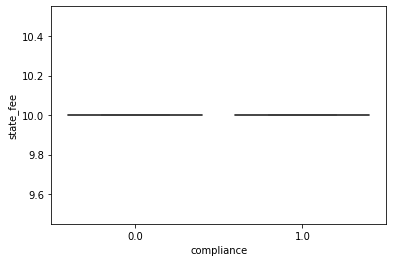

In [29]:
sns.boxplot(data=train_data,y='state_fee',x='compliance')

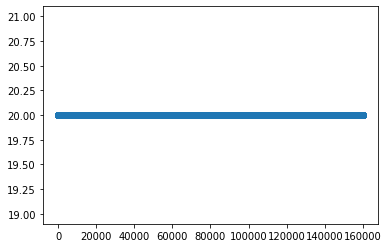

In [30]:
plt.scatter(range(len(train_data['state_fee'])),train_data['admin_fee'])

### 4.6 Discount amount vs Compliance. It seems no obvious difference between compliance and non-compliance for amount of discount

Text(0.5, 1.0, 'Discount amount vs compliance (zoomed in)')

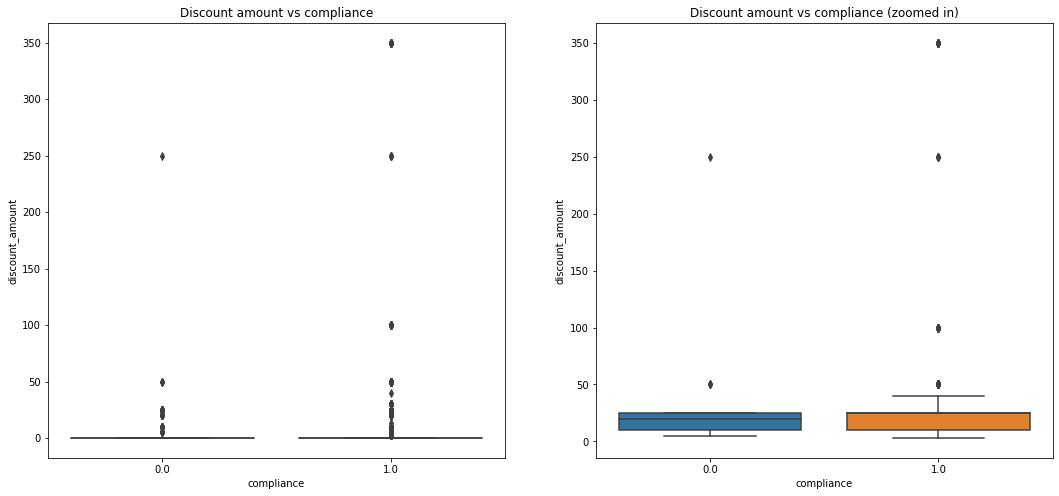

In [31]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_data,y='discount_amount',x='compliance')
plt.title('Discount amount vs compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_data[train_data['discount_amount']!=0],y='discount_amount',x='compliance')
plt.title('Discount amount vs compliance (zoomed in)')

### Everyone has same clean up cost, so we will remove this varaible in our modelling

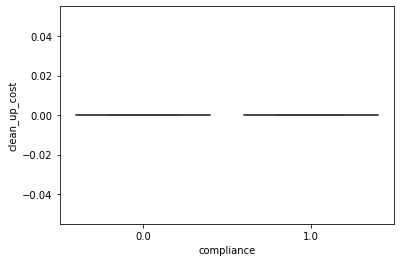

In [32]:
sns.boxplot(data=train_data,y='clean_up_cost',x='compliance')

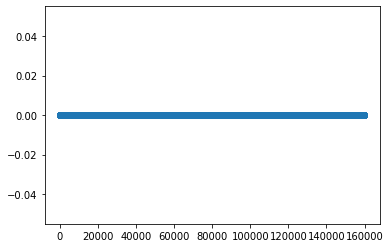

In [33]:
plt.scatter(range(len(train_data['clean_up_cost'])),train_data['clean_up_cost'])

### 4.7 Judgement amount vs Compliance

### Since judgement and fine amount are highly correlated, using both variables may not provide any additional useful information in our model

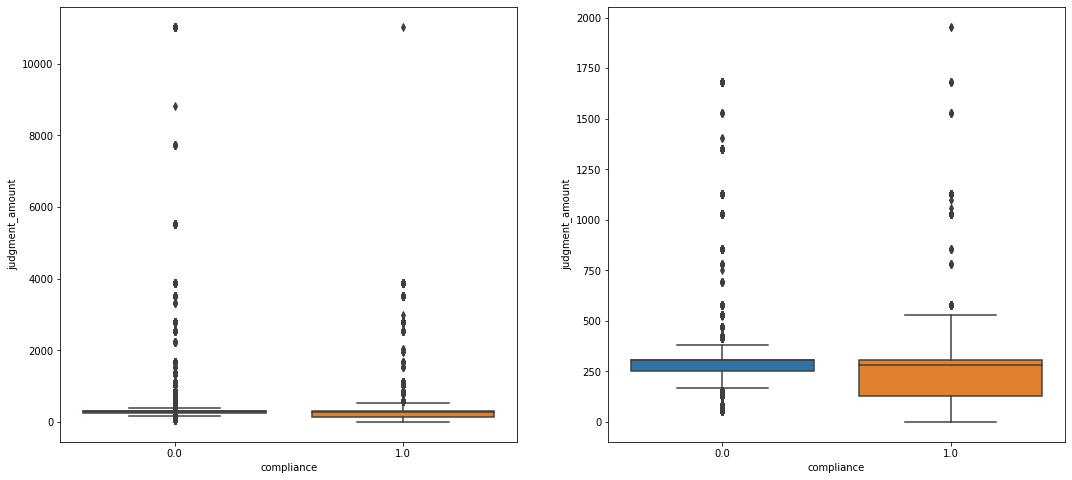

In [34]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_data,y='judgment_amount',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_data[train_data['judgment_amount']<2000],y='judgment_amount',x='compliance')

In [35]:
train_data[['compliance','judgment_amount']].groupby(['compliance']).agg({'count','mean','median','std'})

judgment_amount                           
                       std   count        mean median
compliance                                           
0.0             762.571835  148280  431.585003  305.0
1.0             381.123566   11597  280.886229  280.0

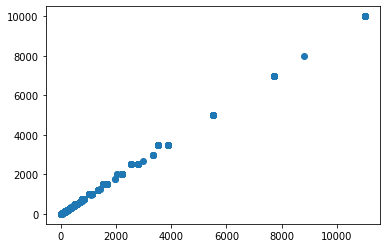

In [36]:
plt.scatter(train_data['judgment_amount'],train_data['fine_amount'])

In [37]:
np.corrcoef(train_data['judgment_amount'],train_data['fine_amount'])

array([[1.        , 0.99989003],
       [0.99989003, 1.        ]])

### 4.8 Time gap vs Compliance shows no obvious difference between compliance and non-compliance





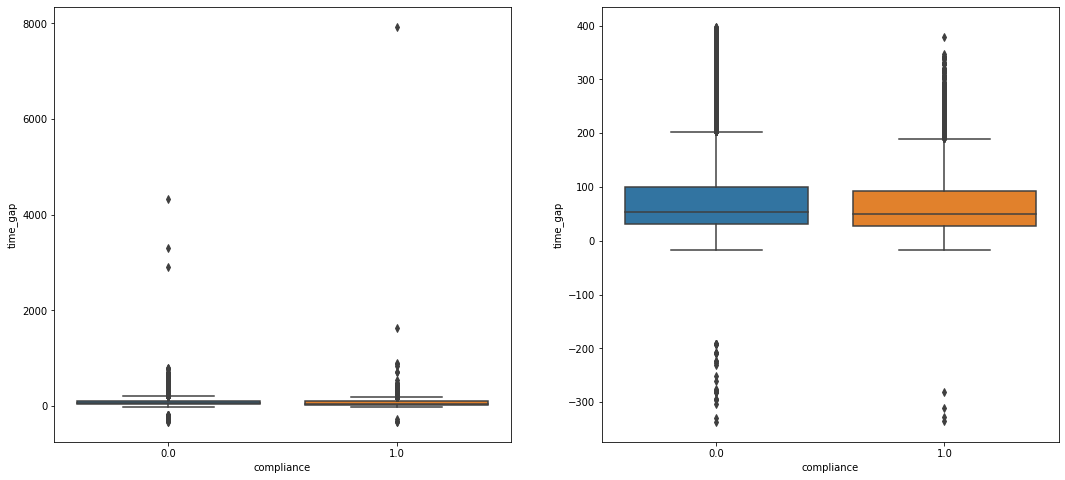

In [38]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_data,y='time_gap',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_data[train_data['time_gap']<400],y='time_gap',x='compliance')

### Additional Data Processing after EDAs

### Dropping state_fee, admin_fee, clean_up_cost, and highly correlated (0.99) judgement_amount



In [39]:
train_data.drop(['state_fee','admin_fee','clean_up_cost','judgment_amount'],axis=1,inplace=True)
test_data.drop(['state_fee','admin_fee','clean_up_cost'],axis=1,inplace=True)


### Remove 
* address
* violator_name
* violation_street_name
* mailing_address_str_number
* violation_street_number
* mailing_address_str_name
* zip_code 

### since we are using latitude and longtitude as way of measure the address.

In [40]:
train_data.drop(['violation_street_number',
                 'mailing_address_str_number',
                 'address',
                 'violation_street_name',
                 'mailing_address_str_name',
                 'zip_code',
                 'violator_name'],axis=1,inplace=True)

### Since we have coded time gap we can remove the ticket_issued_date and hearing_date.

### Since we are using violation_code as categorical variable we will remove the violation_description which is redudant

In [41]:
train_data.drop(['ticket_issued_date',
                 'hearing_date',
                 'violation_description'],axis=1,
                 inplace=True)

## 5. Modelling



###  Label Encoding

In [42]:
#Convert cetegory columns to integers
cat_columns = train_data.select_dtypes(['category']).columns
for df in [train_data,test_data]:
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [43]:
train_data.columns

Index(['agency_name', 'inspector_name', 'city', 'state', 'country',
       'violation_code', 'disposition', 'fine_amount', 'late_fee',
       'discount_amount', 'compliance', 'lat', 'lon', 'time_gap'],
      dtype='object')

### Split the data for training and validation

In [44]:
from sklearn.model_selection import train_test_split
y = train_data['compliance']
X = train_data.drop(['compliance'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

test = test_data.copy()

In [93]:
models = []
accuracy_scores = []
roc_auc_socres = []
precision_scores = []
recall_scores = []
f1_scores = []
specificity_scores = []

### 5.1  Logistic regression

In [45]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

train_data_scaled = train_data.copy()
train_data_scaled [['discount_amount','lat','lon',
                    'time_gap']] = ss.fit_transform(train_data_scaled [['discount_amount','lat','lon',
                    'time_gap']])


y_scaled = train_data_scaled['compliance']
X_scaled = train_data_scaled.drop(['compliance'],axis=1)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, random_state=0)

                    

In [46]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_scaled,y_train_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.9316553706633881


In [47]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.9316553706633881


In [94]:
from sklearn.metrics import confusion_matrix
y_pred_scaled = logreg_cv.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test_scaled, y_pred_scaled ).ravel()



y_proba = logreg_cv.predict_proba(X_test_scaled)[:,1]
y_pred = logreg_cv.predict(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test_scaled, y_proba)
roc_auc  = auc(fpr, tpr)
accuracy = logreg_cv.score(X_test_scaled, y_test_scaled)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score (y_test,y_pred)
specificity = tn/(tn+fp)




print ("ROC AUC: ",roc_auc)
print ("Accuracy: ",accuracy)
print ("Precision: ",precision)
print ("Recall: ",recall)
print ("F1 score: ",f1)
print ("Specificity: ",specificity)

models.append('logistic regression')
accuracy_scores.append(accuracy)
roc_auc_socres.append(roc_auc)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)
specificity_scores.append(specificity)


ROC AUC:  0.7492360838490942
Accuracy:  0.9315736802601952
Precision:  0.7027027027027027
Recall:  0.08153310104529617
F1 score:  0.14611301904464563
Specificity:  0.9973315363881402


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


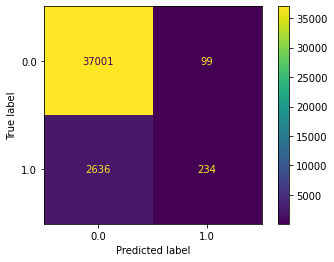

In [51]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_cv,X_test_scaled,y_test_scaled)

### 5.2 Logistic regression with over-sampling for imbalanced response 

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
X_oversample, y_oversample = SMOTE().fit_resample(X_train_scaled,y_train_scaled)

In [74]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg=LogisticRegression()
logreg_cv_over=GridSearchCV(logreg,grid,cv=10)
logreg_cv_over.fit(X_oversample,y_oversample)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [75]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv_over.best_params_)
print("accuracy :",logreg_cv_over.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.7072045331894226


In [95]:
y_pred_scaled = logreg_cv_over.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test_scaled, y_pred_scaled ).ravel()



y_proba = logreg_cv_over.predict_proba(X_test_scaled)[:,1]
y_pred = logreg_cv_over.predict(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test_scaled, y_proba)
roc_auc  = auc(fpr, tpr)
accuracy = logreg_cv_over.score(X_test_scaled, y_test_scaled)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score (y_test,y_pred)
specificity = tn/(tn+fp)




print ("ROC AUC: ",roc_auc)
print ("Accuracy: ",accuracy)
print ("Precision: ",precision)
print ("Recall: ",recall)
print ("F1 score: ",f1)
print ("Specificity: ",specificity)

models.append('logistic regression with over sampling')
accuracy_scores.append(accuracy)
roc_auc_socres.append(roc_auc)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)
specificity_scores.append(specificity)


ROC AUC:  0.7672311015524478
Accuracy:  0.7959969977483112
Precision:  0.19300488031605856
Recall:  0.5787456445993031
F1 score:  0.2894736842105263
Specificity:  0.8128032345013477


### 5.2 Gradient Boosting Classifier

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [53]:
grid_values = {'learning_rate':[0.01,0.1],
               'max_depth':[3,5]}
GB_clf = GradientBoostingClassifier(random_state = 0)
grid_gb_clf = GridSearchCV(GB_clf,grid_values,scoring = 'roc_auc')
grid_gb_clf.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
             scoring='roc_auc')

In [96]:
y_proba = grid_gb_clf.predict_proba(X_test)[:,1]
y_pred = grid_gb_clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()



fpr_GBC, tpr_GBC, _ = roc_curve(y_test, y_proba)
roc_auc_GBC  = auc(fpr_GBC, tpr_GBC)
accuracy_GBC = grid_gb_clf.score(X_test, y_test)






fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc  = auc(fpr, tpr)
accuracy = grid_gb_clf.score(X_test, y_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score (y_test,y_pred)
specificity = tn/(tn+fp)




print ("ROC AUC: ",roc_auc)
print ("Accuracy: ",accuracy)
print ("Precision: ",precision)
print ("Recall: ",recall)
print ("F1 score: ",f1)
print ("Specificity: ",specificity)

models.append('Gradient Boosting Classifier')
accuracy_scores.append(accuracy)
roc_auc_socres.append(roc_auc)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)
specificity_scores.append(specificity)


ROC AUC:  0.8287864233590352
Accuracy:  0.8287864233590352
Precision:  0.8571428571428571
Recall:  0.2529616724738676
F1 score:  0.390637610976594
Specificity:  0.9967385444743936


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


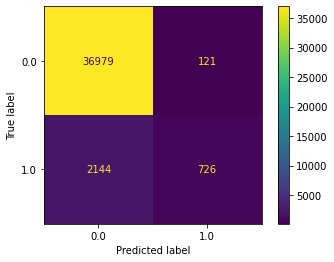

In [69]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(grid_gb_clf,X_test,y_test)

### 5.3 Random Forest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth':[  5,6,7],'min_samples_leaf':[ 3,4], 'min_samples_split':[5,10]}

clf = RandomForestClassifier(random_state=0)

RF_clf = GridSearchCV(clf,parameters,scoring='roc_auc')
RF_clf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 6, 7], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [5, 10]},
             scoring='roc_auc')

In [70]:
y_proba_rf = RF_clf.predict_proba(X_test)[:,1]
y_pred = RF_clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [97]:
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_proba)
roc_auc_RF  = auc(fpr_RF, tpr_RF)
accuracy_RF = RF_clf.score(X_test, y_test)


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc  = auc(fpr, tpr)
accuracy = RF_clf.score(X_test, y_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score (y_test,y_pred)
specificity = tn/(tn+fp)


print ("ROC AUC: ",roc_auc)
print ("Accuracy: ",accuracy)
print ("Precision: ",precision)
print ("Recall: ",recall)
print ("F1 score: ",f1)
print ("Specificity: ",specificity)

models.append('Random Foreste Classifier')
accuracy_scores.append(accuracy)
roc_auc_socres.append(roc_auc)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)
specificity_scores.append(specificity)


ROC AUC:  0.8287864233590352
Accuracy:  0.8193218535458362
Precision:  0.8571428571428571
Recall:  0.2529616724738676
F1 score:  0.390637610976594
Specificity:  0.9967385444743936


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


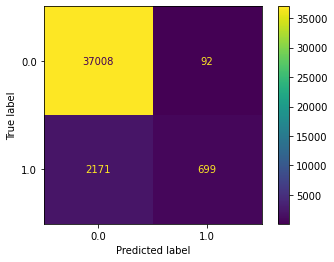

In [59]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RF_clf,X_test,y_test)

### 5.4XGboosting Classifier

In [84]:
import xgboost as xgb

params = {
        'colsample_bytree': [0.3, 0.5, 0.8],
        'reg_alpha':[0,0.5,1,5],
        'reg_lambda':[0,0.5,1,5]
        }


clf =xgb.XGBClassifier(random_state = 0)


xgb_clf = GridSearchCV(clf,params,scoring='roc_auc')
xgb_clf.fit(X_train,y_train)

y_pred = xgb_clf.predict(X_test)

y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb  = auc(fpr_xgb, tpr_xgb)
accuracy_xgb = xgb_clf.score(X_test, y_test)

print("accuracy = {:.4f}   AUC = {:.4f}".format(accuracy_xgb,  roc_auc_xgb))

accuracy = 0.9434   AUC = 0.8226


In [98]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc  = auc(fpr, tpr)
accuracy = xgb_clf.score(X_test, y_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score (y_test,y_pred)
specificity = tn/(tn+fp)


print ("ROC AUC: ",roc_auc)
print ("Accuracy: ",accuracy)
print ("Precision: ",precision)
print ("Recall: ",recall)
print ("F1 score: ",f1)
print ("Specificity: ",specificity)


models.append('XGboosting Classifier')
accuracy_scores.append(accuracy)
roc_auc_socres.append(roc_auc)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)
specificity_scores.append(specificity)


ROC AUC:  0.8287864233590352
Accuracy:  0.943382536902677
Precision:  0.8571428571428571
Recall:  0.2529616724738676
F1 score:  0.390637610976594
Specificity:  0.9967385444743936


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


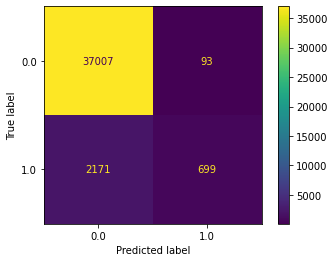

In [82]:
plot_confusion_matrix(xgb_clf,X_test,y_test)

In [99]:
models_scores = pd.DataFrame()
models_scores['models'] = models
models_scores['roc_auc'] = roc_auc_socres
models_scores['accuracy'] = accuracy_scores
models_scores['precision'] = precision_scores
models_scores['recall'] = recall_scores
models_scores['f1'] = f1_scores
models_scores['specificity'] = specificity_scores

In [100]:
models_scores

,models,roc_auc,accuracy,precision,recall,f1,specificity
0,logistic regression,0.749236,0.931574,0.702703,0.081533,0.146113,0.997332
1,logistic regression with over sampling,0.767231,0.795997,0.193005,0.578746,0.289474,0.812803
2,Gradient Boosting Classifier,0.828786,0.828786,0.857143,0.252962,0.390638,0.996739
3,Random Foreste Classifier,0.828786,0.819322,0.857143,0.252962,0.390638,0.996739
4,XGboosting Classifier,0.828786,0.943383,0.857143,0.252962,0.390638,0.996739


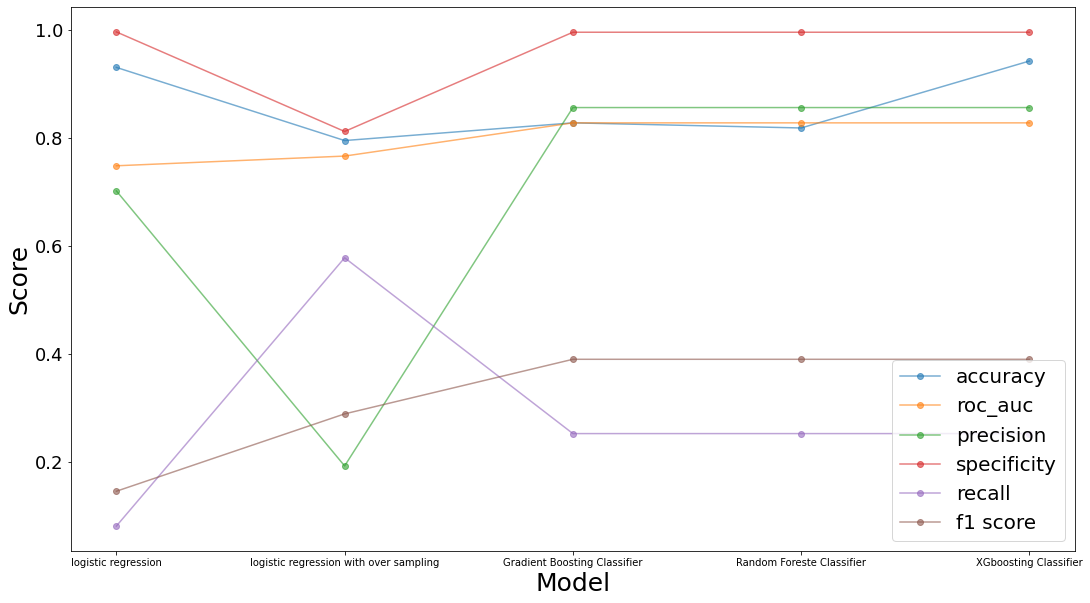

In [102]:
plt.figure(figsize=(18,10))
plt.plot(models_scores['models'],models_scores['accuracy'],label='accuracy',marker='o',alpha=0.6)
plt.plot(models_scores['models'],models_scores['roc_auc'],label='roc_auc',marker='o',alpha=0.6)
plt.plot(models_scores['models'],models_scores['precision'],label='precision',marker='o',alpha=0.6)
plt.plot(models_scores['models'],models_scores['specificity'],label='specificity',marker='o',alpha=0.6)
plt.plot(models_scores['models'],models_scores['recall'],label='recall',marker='o',alpha=0.6)
plt.plot(models_scores['models'],models_scores['f1'],label='f1 score',marker='o',alpha=0.6)
plt.xlabel('Model',size=25)
plt.ylabel('Score',size=25)
plt.yticks(size=18)
plt.legend(prop={'size': 20})

## 6 Model Performance
### 6.1  Comparison between models
* For Gradient Boosting Classifier, Random Forest Classifier and XGboosting Classifier, the accuracy, roc_auc and precision are very similar, the only difference is that XGboosting Classifier has higher accuracy.
* There is qute some opposite behaviour for precision and recall scores for logistic regression and logistic regression with over sampling.


### 6.2. Choosing the reasonable metrics
* We would like to understand the cost of wrong prediction.
* Since the goal is to predict if an individual will payment to their property maintenance, we want to reduce the error predicting number of people who may fail to pay fines on time. In other words, we want to reduce the number of falso positive as much as possibile which means greater specificity and precision scores.

### Picking the models
* We will pick XGboosting Classifier since it has the highest specificity and precision scores. Also, the ROC AUC is higher compared to the two logistic regression models. The reason we pick XGboosting over Random Forest and Gradient Boosting is because of higher accuracy.

In [120]:
x_names = train_data.columns.tolist()
x_names.remove('compliance')

In [121]:
X_test_data = test_data[x_names]

In [126]:
X_test_data['lat'].fillna(method='pad',inplace=True)
X_test_data['lon'].fillna(method='pad',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [142]:
y_pred_test = xgb_clf.predict(X_test_data)
y_prob_test_pos = xgb_clf.predict_proba(X_test_data)[:,1]
y_prob_test_neg = xgb_clf.predict_proba(X_test_data)[:,0]

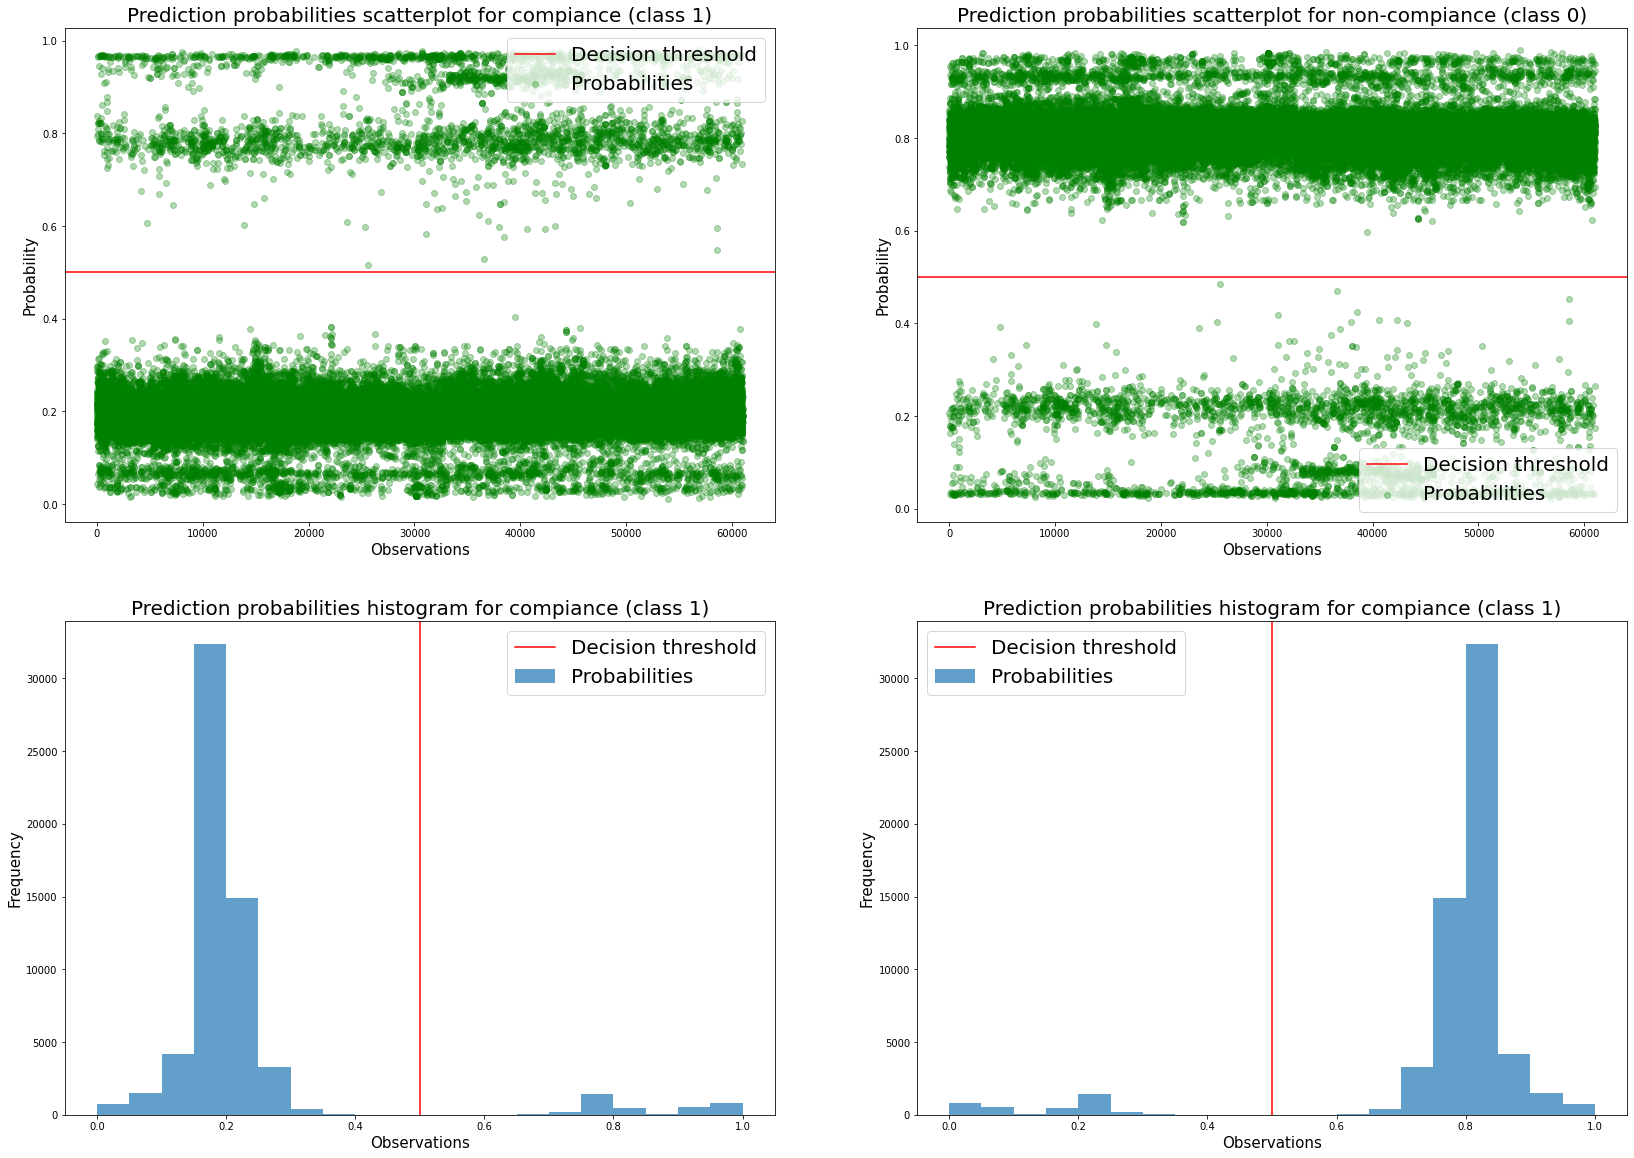

In [143]:
plt.figure(figsize=(28,20))
plt.subplot(2,2,1)
plt.scatter(range(len(y_prob_test_pos)),y_prob_test_pos,color='green',alpha=0.3,label='Probabilities')
plt.axhline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities scatterplot for compiance (class 1)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Probability',size=15)
plt.legend(loc='upper right',prop={'size': 20})

plt.subplot(2,2,2)
plt.scatter(range(len(y_prob_test_neg)),y_prob_test_neg,color='green',alpha=0.3,label='Probabilities')
plt.axhline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities scatterplot for non-compiance (class 0)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Probability',size=15)
plt.legend(loc='lower right',prop={'size': 20})

plt.subplot(2,2,3)
plt.hist(y_prob_test_pos,range=(0,1),bins=20,alpha=0.7,label='Probabilities')
plt.axvline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities histogram for compiance (class 1)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Frequency',size=15)
plt.legend(prop={'size': 20})

plt.subplot(2,2,4)
plt.hist(y_prob_test_neg,range=(0,1),bins=20,alpha=0.7,label='Probabilities')
plt.axvline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities histogram for compiance (class 1)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Frequency',size=15)
plt.legend(prop={'size': 20})